In [541]:
#importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import random
import datetime
import holidays
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import gensim.corpora as corpora
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import tmtoolkit
from transformers import pipeline
random.seed(123)
%matplotlib inline
mpl.rcParams['figure.figsize'] = [10,8]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kubawarmuz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [462]:
!pip install sklearn 

In [34]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')
print("Shape:", df.shape)
df.head()

Shape: (509236, 8)


,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


## Exploratory Data Analysis (EDA)

First, I want to understand the data better. For this purpose, I will conduct an exploratory data analysis. This will include the examination of unique values, distributions over variables of interest, oftentimes grouped in a way that delives more insight, and correlations between the covariates.

In [8]:
df[['title', 'author', 'category']].nunique()

title       500720
author       85838
category         1
dtype: int64

In [9]:
df['up_votes'].describe()

count    509236.000000
mean        112.236283
std         541.694675
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max       21253.000000
Name: up_votes, dtype: float64

In [10]:
df['down_votes'].describe()

count    509236.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: down_votes, dtype: float64

In [15]:
df['over_18'].value_counts()

False    508916
True        320
Name: over_18, dtype: int64

In [16]:
df.isna().sum()

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64

#### First findings

Columns of 'down_votes' and 'category' contain no information. All of values on these columns are the same and there are no nans. Because of that, I will remove these columns, as they could only potentially produce noise and defintely would increase the dimension of the dataset, which could have adverse impacts on ML models that I will create.

In [35]:
df = df.drop(columns=['down_votes', 'category'])

Text(0, 0.5, 'Frequency')

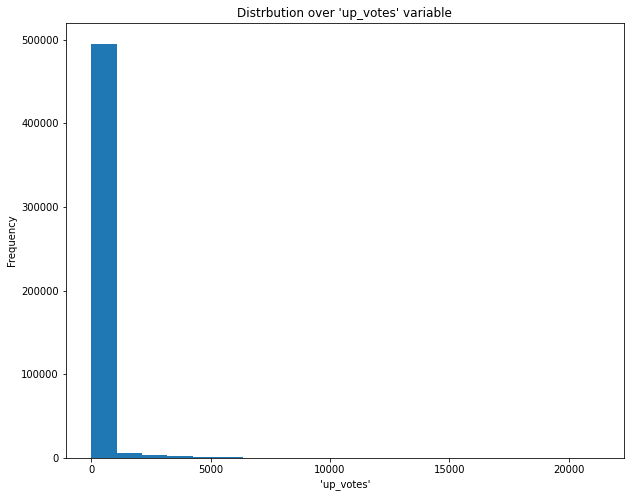

In [31]:
plt.figure()
plt.hist(df['up_votes'], bins=20)
plt.title("Distrbution over 'up_votes' variable")
plt.xlabel("'up_votes'")
plt.ylabel("Frequency")

As we can see, the distribution is heavily skewed. Most of the content generates only a few upvotes. There are some pieces that attract more positive engagement, however only very few garnered virality and amassed an outstanding number of upvotes. In fact, 75th percentile on up_votes variable is equal to only 16. This means that 75% of all videos got only 16 upvotes. Because of this heavy skewness, I will need to do something about the outliers. One thing that can be done is to remove them from the dataset completely. This, however, is not a preferential method for me, as there might be a lot of information hidden in those 'outlier' content pieces. Additionally, it is usually those outliers that generate the most traffic, content, and value, especially for digital companies (IG influencers, top artists on Spotify, best content and podcast creators on YT, etc). Because of that, I will want to examine them deeper. Thus, I will only 'crop' the data: whenever value of 'up_votes' column exceeds a certain number, I will change it to this particular number. I will choose 100 to be this threshold. 

In [32]:
len(df[df['up_votes']>100])

50215

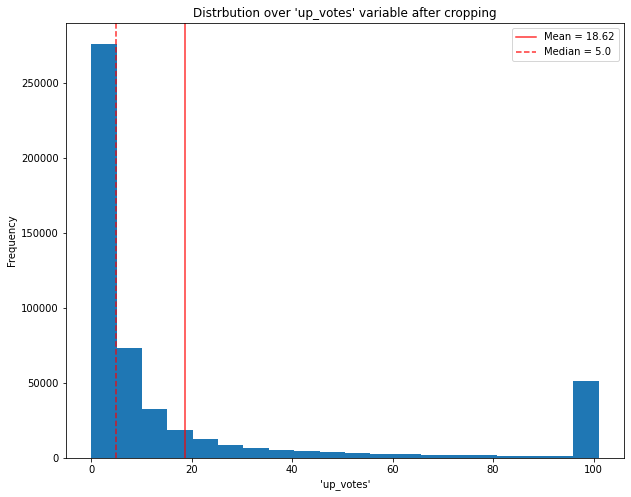

In [45]:
crop_upvotes = lambda x: 101 if x > 100 else x
df['up_votes'] = df['up_votes'].apply(crop_upvotes)
plt.figure()
plt.hist(df['up_votes'], bins=20)
plt.title("Distrbution over 'up_votes' variable after cropping")
plt.xlabel("'up_votes'")
plt.ylabel("Frequency")
plt.axvline(np.mean(df['up_votes']), color='red', alpha=0.8, label=f"Mean = {np.round(np.mean(df['up_votes']), 2)}")
plt.axvline(np.median(df['up_votes']), color='red', alpha=0.8, linestyle='--', label=f"Median = {np.median(df['up_votes'])}")
plt.legend()

In [37]:
df['up_votes'].describe()

count    509236.000000
mean         18.623699
std          31.160075
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max         101.000000
Name: up_votes, dtype: float64

Text(0.5, 1.0, 'Median # of upvotes per content type')

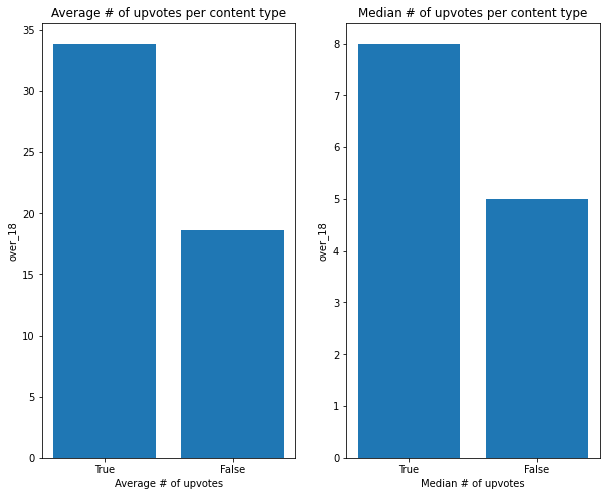

In [50]:
# average and median number of upvotes for over_18
avg_up_over = np.mean(df[df['over_18']==True]['up_votes'])
avg_up_under = np.mean(df[df['over_18']==False]['up_votes'])
median_up_over = np.median(df[df['over_18']==True]['up_votes'])
median_up_under = np.median(df[df['over_18']==False]['up_votes'])

vals = ('True', 'False')
ys = np.arange(len(vals))
plt.figure()

plt.subplot(1,2,1)
plt.bar(ys, [avg_up_over, avg_up_under], align='center')
plt.xticks(ys, vals)
plt.ylabel('over_18')
plt.xlabel('Average # of upvotes')
plt.title('Average # of upvotes per content type')

plt.subplot(1,2,2)
plt.bar(ys, [median_up_over, median_up_under], align='center')
plt.xticks(ys, vals)
plt.ylabel('over_18')
plt.xlabel('Median # of upvotes')
plt.title('Median # of upvotes per content type')

As we can see, +18 content generates less positive engagement from the community. It might be for a couple of reasons. First, oolder audiences might be less likely to give out upvotes, as they might be more conservative with their judgement, or they might not want others to see that they are watching and liking 18+ content. Another reason could be the type of content that is labeled 18+. It could be the case that this type of content is, in general, less positive, sparking less of positive reactions. An example of such content could be reporting on war with pictures from the battlefield. The type of content (topics) will be examined futher in this notebook. Now, I will proceed with analyzing the authors. 

In [103]:
author_grouped = df[['up_votes']].groupby(df['author']).agg(['count', 'mean']).sort_values(('up_votes', 'count'), ascending=False)
author_grouped[:10]

up_votes           
                 count       mean
author                           
davidreiss666     8897  13.964258
anutensil         5730  38.278185
DoremusJessup     5037  21.363907
maxwellhill       4023  53.922695
igeldard          4013   7.695240
readerseven       3170  13.959937
twolf1            2923  15.779336
madam1            2658  24.252822
nimobo            2564  19.350234
madazzahatter     2503  25.051938

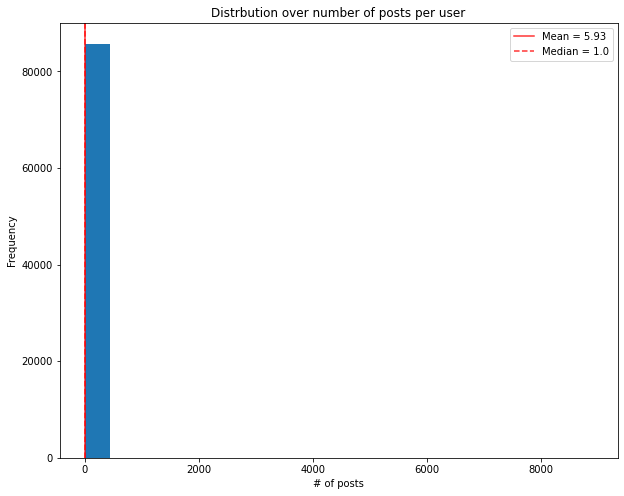

In [91]:
plt.figure()
plt.hist(author_grouped['up_votes', 'count'], bins=20)
plt.title("Distrbution over number of posts per user")
plt.xlabel("# of posts")
plt.ylabel("Frequency")
plt.axvline(np.mean(author_grouped['up_votes', 'count']), color='red', alpha=0.8, label=f"Mean = {np.round(np.mean(author_grouped['up_votes', 'count']), 2)}")
plt.axvline(np.median(author_grouped['up_votes', 'count']), color='red', alpha=0.8, linestyle='--', label=f"Median = {np.median(author_grouped['up_votes', 'count'])}")
plt.legend()

As we can see, the vast majority of users post only one video. It is only a handful of individuals who are proliferate content creators.

In [101]:
print("Number of authors who posted more than once:", sum(author_grouped['up_votes', 'count']>1))
print("% of authors who posted more than once:", np.round((sum(author_grouped['up_votes', 'count']>1)/len(author_grouped['up_votes', 'count']))*100, 2))
print()
print("Number of authors who posted more than 10 times:", sum(author_grouped['up_votes', 'count']>10))
print("% of authors who posted more than 10 times:", np.round((sum(author_grouped['up_votes', 'count']>10)/len(author_grouped['up_votes', 'count']))*100, 2))
print()
print("Number of authors who posted more than 50 times:", sum(author_grouped['up_votes', 'count']>50))
print("% of authors who posted more than 50 times:", np.round((sum(author_grouped['up_votes', 'count']>50)/len(author_grouped['up_votes', 'count']))*100, 2))
print()
print("Number of authors who posted more than 100 times:", sum(author_grouped['up_votes', 'count']>100))
print("% of authors who posted more than 100 times:", np.round((sum(author_grouped['up_votes', 'count']>100)/len(author_grouped['up_votes', 'count']))*100, 2))

Number of authors who posted more than once: 31198
% of authors who posted more than once: 36.35

Number of authors who posted more than 10 times: 5750
% of authors who posted more than 10 times: 6.7

Number of authors who posted more than 50 times: 1290
% of authors who posted more than 50 times: 1.5

Number of authors who posted more than 100 times: 592
% of authors who posted more than 100 times: 0.69


In [120]:
# How much content do the users who have shared more than 50 videos generate?
# I assume that this most proliferate 1.5% of authors generate a vast majority of content shared on Eluvio
# getting the number of users that generated more than 50 videos
n_top_users = (sum(author_grouped['up_votes', 'count']>50))
print("Number of users that have shared more than 50 videos:", n_top_users)
proliferate_users = list(author_grouped.index[:n_top_users])
df['by_proliferate_user'] = df['author'].apply(lambda x: True if x in proliferate_users else 0)
print(f"% of content generated by the top 1.5% of the most proliferate users: {np.round((sum(df['by_proliferate_user'])/len(df)*100), 2)}")
df = df.drop(columns=['by_proliferate_user'])

Number of users that have shared more than 50 videos: 1290
% of content generated by the top 1.5% of the most proliferate users: 52.66


Given the finding above, I want to know whether being a proliferate author increases one's chance of having a viral post. I label an author as 'proliferate' when their total number of posts exceeds 50 and a viral post as one that has more than 100 upvotes. There arises a question of how the label for being proliferate or no should be given. First approach would be to give it to each author that has +50 videos in the entire dataset. Second approach would be to give that label only when the number of videos published until the time of publishing is above 50. The second option seems more reasonable, as with the first method we would be introducing a form of lookahead bias: in reality, we do not know if any given author will go on and post more than 50 times before they actually do. The number of upvotes received might be a certain predictor of that (and other variables, not included in this dataset), however the principle still holds and we should avoid introducing any biases into the dataset. Because of that, I will use the second approach.

In [129]:
df['posted_before'] = df.groupby('author').cumcount()
df['proliferate'] = df['posted_before']>50

proliferate_true = df[df['proliferate']==True]
proliferate_false = df[df['proliferate']==False]

print("Average number of upvotes by proliferate authors:", np.mean(proliferate_true['up_votes']))
print("Average number of upvotes by non-proliferate authors:", np.mean(proliferate_false['up_votes']))

print("% of videos posted by proliferate users that went viral:", 100*(len(proliferate_true[proliferate_true['up_votes']>100])/len(proliferate_true)))
print("% of videos posted by non-proliferate users that went viral:", 100*(len(proliferate_false[proliferate_false['up_votes']>100])/len(proliferate_false)))

Average number of upvotes by proliferate authors: 19.706577328451356
Average number of upvotes by non-proliferate authors: 17.909528480507333
% of videos posted by proliferate users that went viral: 10.383096893421683
% of videos posted by non-proliferate users that went viral: 9.516422852189441


It seems like the users who have experience with publishing videos get more upvotes and have a higher likelihood of their post going viral. To confirm it, I use statistical hypothesis testing. In particular, I use the Kolmogorov-Smirnov test on 2 samples. This test tells us if the 2 samples are generated from the same underlying distribution (althugh it does not specfy what this distribution is). I do not use the most popular T-test statistic as it assumes that the data comes from a normal distribution and I have already observed that this is not the case.

In [134]:
from scipy.stats import ks_2samp

ks_stat, p = ks_2samp(proliferate_true['up_votes'], proliferate_false['up_votes'])

print('p-value =', p)

if p > 0.05:
	print('Difference in distributions is not statistically significant')
else:
	print('Difference in distributions is statistically significant')

p-value = 9.28891336598074e-269
Difference in distributions is statistically significant


Now, I want to observe how the probability of having a viral video scales as a function of the number of posts published by the author. The best way to learn about this propety of the data is to plot it. I will do just that below.

Slope of the line of best fit: -3.985619807922986e-06


Text(0.5, 1.0, 'Mean % of viral videos as a function of the number of videos posted before by the user')

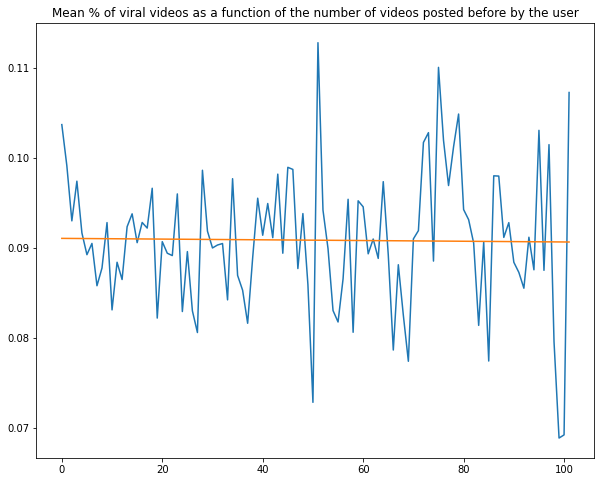

In [176]:
# creating a labele for our metric of interest
df['viral'] = df['up_votes']>100

# for the purposes of visualizations, I will put a cap on the number of videos shared
# if a user has shared more than 100 posts, I will crop his/her total number to be 101
crop_posts = lambda x: 101 if x > 100 else x
df['posted_before'] = df['posted_before'].apply(crop_posts)

# groupby function to obtain the mean number of viral posts per a group of users with the same number of posts shared before
dff = df[['viral']].groupby(df['posted_before']).agg(['sum', 'count', 'mean'])

xs = np.array(dff.index)
ys = np.array(dff[('viral', 'mean')])
m, b = np.polyfit(xs, ys, 1)

print("Slope of the line of best fit:", m)
plt.figure()
plt.plot(xs, ys)
plt.plot(xs, m*xs + b)
plt.title("Mean % of viral videos as a function of the number of videos posted before by the user")


There doesn't seem to be much strict correlation between the number of posts by author (their experience) and the probability of getting a viral post. 

#### Time analysis

In [181]:
df['timestamp'] = pd.to_datetime(df['time_created'], unit='s')
df.head()

,time_created,date_created,up_votes,title,over_18,author,posted_before,proliferate,viral,timestamp
0,1201232046,2008-01-25,3,Scores killed in Pakistan clashes,False,polar,0,False,False,2008-01-25 03:34:06
1,1201232075,2008-01-25,2,Japan resumes refuelling mission,False,polar,1,False,False,2008-01-25 03:34:35
2,1201232523,2008-01-25,3,US presses Egypt on Gaza border,False,polar,2,False,False,2008-01-25 03:42:03
3,1201233290,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420,0,False,False,2008-01-25 03:54:50
4,1201274720,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,0,False,False,2008-01-25 15:25:20


In [182]:
# time_created and date_created columns basically contain the same information but time_created is more accurate
# I converted the time_created into the timestamp format from which we can derive more information than from the integer timestamp
# I will remove the remaining time_created and date_created columns as they are redundant now
df = df.drop(columns=['time_created', 'date_created'])

Text(0.5, 1.0, 'Total number of upvotes in a year (user engagement with Eluvio)')

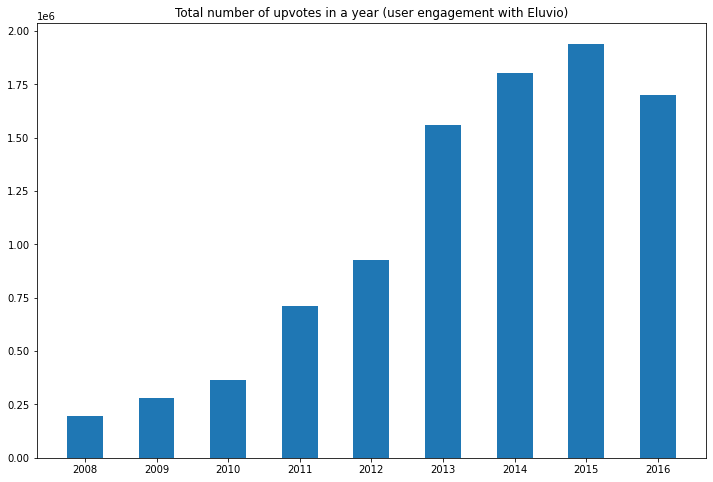

In [186]:
years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
dff = df.groupby(pd.Grouper(key='timestamp',freq='Y')).sum()

plt.figure(figsize=[12,8])
plt.bar(years, dff['up_votes'], width=0.5)
plt.title("Total number of upvotes in a year (user engagement with Eluvio)")

This graph represents the steady graph of the company in terms of user engagement. Each subsequent year, the company experiences more engagement from the users, which is na evidence of their satisfaction with the product. 2016 has a lower value than 2015 because the last month of 2016 was missing from the data.

Text(0.5, 1.0, 'Average number of upvotes for videos posted in a given month')

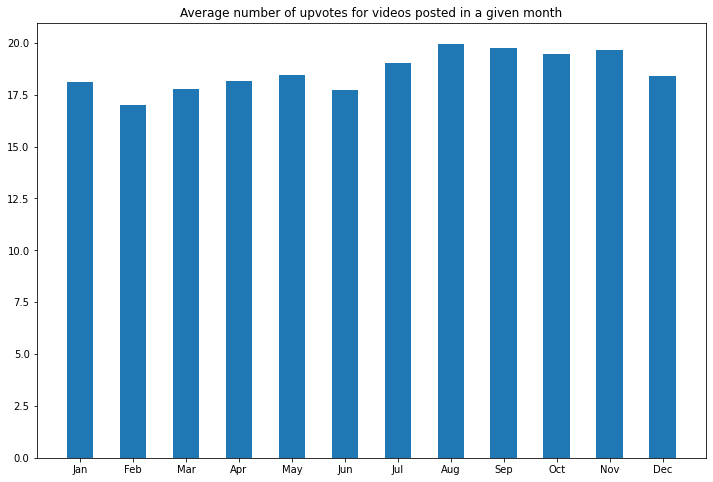

In [200]:
months = ['Jan', 'Feb', 'Mar', "Apr", "May", "Jun", "Jul", "Aug", 'Sep', 'Oct', 'Nov', 'Dec']

df['month'] = df['timestamp'].apply(lambda x: x.month)

dff = df[['up_votes', 'viral']].groupby(df['month']).agg(['sum', 'count', 'mean'])

plt.figure(figsize=[12,8])
plt.bar(months, dff['up_votes']['mean'].values.tolist(), width=0.5)
plt.title("Average number of upvotes for videos posted in a given month")

Text(0.5, 1.0, 'Average % of viral posts for videos posted in a given month')

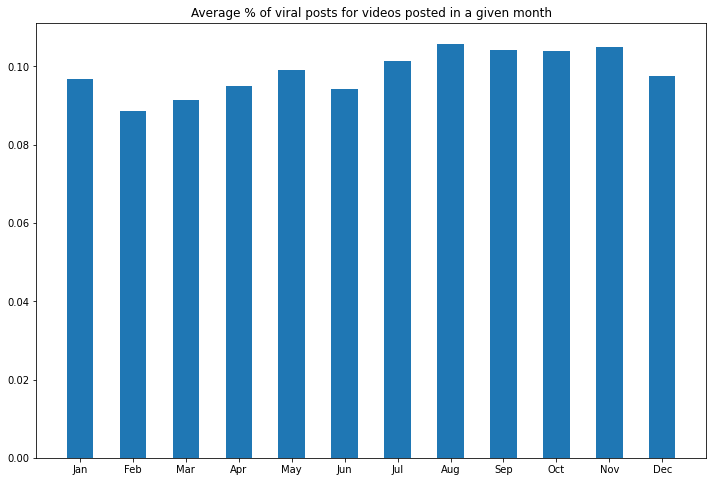

In [201]:
plt.figure(figsize=[12,8])
plt.bar(months, dff['viral']['mean'].values.tolist(), width=0.5)
plt.title("Average % of viral posts for videos posted in a given month")

No significant irregularities observed in the distribution of user engagement over months

Text(0.5, 1.0, 'Average number of upvotes for videos posted in a given day of the week')

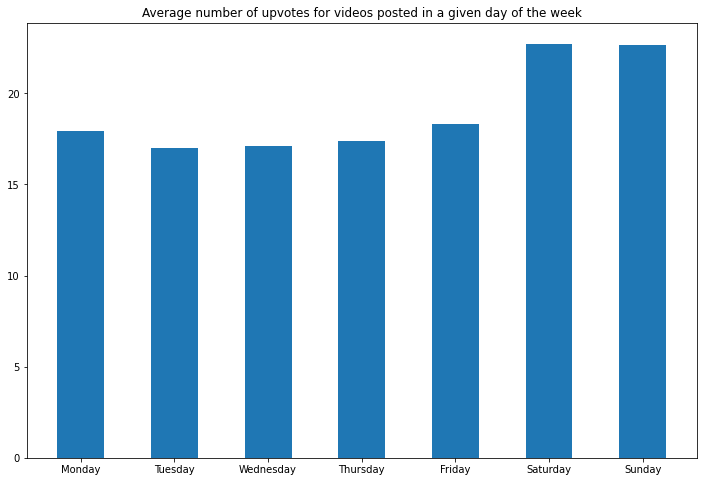

In [223]:
days_list = ['Monday', 'Tuesday', 'Wednesday', "Thursday", "Friday", "Saturday", "Sunday"]

df['day_of_week'] = df['timestamp'].apply(lambda x: x.weekday())

dff = df[['up_votes', 'viral']].groupby(df['day_of_week']).agg(['sum', 'count', 'mean'])

plt.figure(figsize=[12,8])
plt.bar(days_list, dff['up_votes']['mean'].tolist(), width=0.5)
plt.title("Average number of upvotes for videos posted in a given day of the week")

Text(0.5, 1.0, 'Average % of viral posts for videos posted in a given week day')

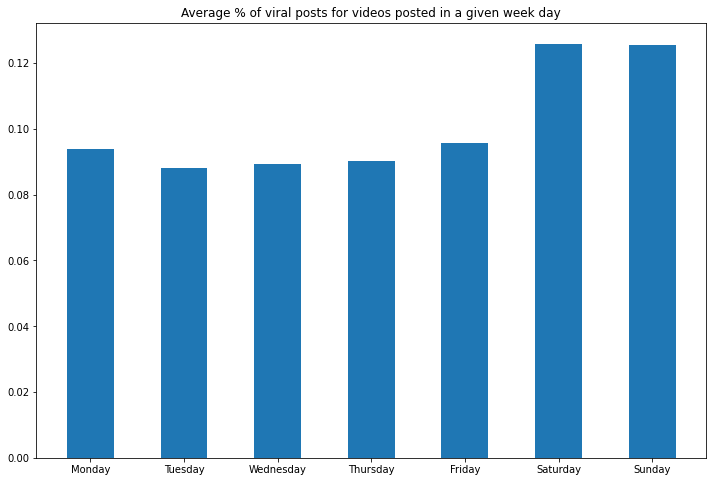

In [224]:
plt.figure(figsize=[12,8])
plt.bar(days_list, dff['viral']['mean'].tolist(), width=0.5)
plt.title("Average % of viral posts for videos posted in a given week day")

Based on the above two graphs, we can see that sharing a video overr the weekend significantly increases the chance of that video getting viral and receiving more upvotes. It is expected; durign the weekends, people usually have more free time and some choose to consume more online content. I will create a new column that checks if the video was posted on one of those two peak days.

In [390]:
df['is_weekend'] = df['day_of_week'].apply(lambda x: x in [5,6])

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Text(0.5, 0, 'Average % of viral videos')

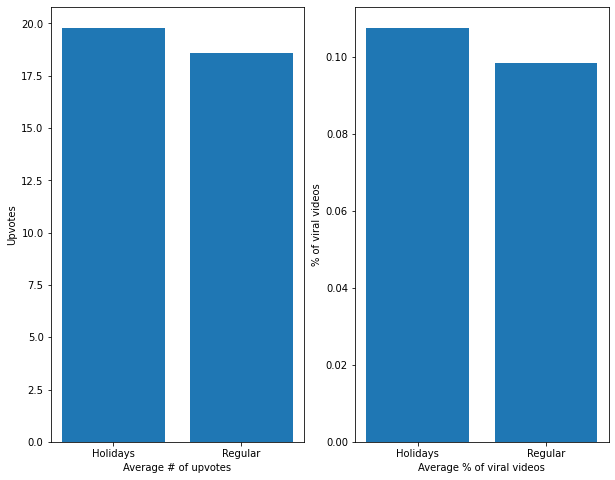

In [234]:
# Select country
us_holidays = holidays.US()

df['is_holiday'] = df['timestamp'].apply(lambda x: x in us_holidays)

# average and median number of upvotes for over_18
avg_viral_holidays = np.mean(df[df['is_holiday']==True]['viral'])
avg_viral_regular = np.mean(df[df['is_holiday']==False]['viral'])
avg_upvotes_holidays = np.mean(df[df['is_holiday']==True]['up_votes'])
avg_upvotes_regular = np.mean(df[df['is_holiday']==False]['up_votes'])

vals = ('Holidays', 'Regular')
ys = np.arange(len(vals))
plt.figure()

plt.subplot(1,2,1)
plt.bar(ys, [avg_upvotes_holidays, avg_upvotes_regular], align='center')
plt.xticks(ys, vals)
plt.ylabel('Upvotes')
plt.xlabel('Average # of upvotes')

plt.subplot(1,2,2)
plt.bar(ys, [avg_viral_holidays, avg_viral_regular], align='center')
plt.xticks(ys, vals)
plt.ylabel('% of viral videos')
plt.xlabel('Average % of viral videos')

Similarly to theo nes posted on the weekend, the videos that are shared on holidays get more upvotes on average and are more likely to become viral

## NLP

### Latent Dirichlet Allocation (LDA)

LDA is an NLP algorithm for topic modelling. LDA assumes that each document can be represented as a mixture of topics and that each topic spits out random words with certain probabilities. For instance, a legal document might be 65% legal, 25% financial and 5% ethical. Within each of those topics, all of the words in english dictionary (or any other language for that matter) have a certain probability of getting drawn. Thus, the text is just a result of probabilistic random words generation. LDA strives to find such mixtures of topics and word probabilities within them so that the generation of a text similar to the one observed (in the training set) has the highest likelihood. 

We can use LDA for topic modelling. This unsupervised learning technique helps us understand what are the main distinctive topics that are present in the text. In our case, that represents different topics of the videos. One hope for the algorithm's output is that it will distinguish political news from economical news or distinguish the topics to represent different world regions that the videos report on.

In [313]:
# data pre-processing
df['title_cleaned'] = df['title'].str.replace("\r", " ")
df['title_cleaned'] = df['title_cleaned'].str.replace("\n", " ")
df['title_cleaned'] = df['title_cleaned'].str.replace("    ", " ")
# " when quoting text
df['title_cleaned'] = df['title_cleaned'].str.replace('"', '')
# lowercase
df['title_cleaned'] = df['title_cleaned'].str.lower()
# punctuation signs
punctuation_signs = list("?:!.,;")

for punct_sign in punctuation_signs:
    df['title_cleaned'] = df['title_cleaned'].str.replace(punct_sign, '')
    
# possessve pronouns
df['title_cleaned'] = df['title_cleaned'].str.replace("'s", "")

words = df['title_cleaned'].values.tolist()
words = ' '.join(words)

text_tokens = word_tokenize(words)

tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [314]:
lda = LatentDirichletAllocation(n_components=5)
cv = CountVectorizer(max_df = 0.97, min_df = 0.001, stop_words = 'english')

words_vect = cv.fit_transform(tokens_without_sw)
lda.fit(words_vect)
transformed_text = lda.transform(words_vect)
# Printing components
for index, topic in enumerate(lda.components_):
    print(f'Top {no_top_words} words for Topic #{index+1}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-no_top_words:-1]])
    print('\n')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Top 10 words for Topic #1
['saudi', 'iraq', 'death', 'chinese', 'years', 'attack', 'killed', 'government', 'new']


Top 10 words for Topic #2
['islamic', 'dead', 'egypt', 'japan', 'isis', 'korea', 'south', 'north', 'world']


Top 10 words for Topic #3
['leader', 'court', 'country', 'israeli', 'ukraine', 'said', 'minister', 'news', 'russian']


Top 10 words for Topic #4
['say', 'report', 'turkey', 'nuclear', 'india', 'uk', 'state', 'police', 'syria']


Top 10 words for Topic #5
['gaza', 'british', 'attacks', 'pakistan', 'syrian', 'year', 'military', 'people', 'iran']




The top words from eahc of the identified topic seem to be quite similar although slightly different. Given that all of the videos are from the worldnews category, it is expected that the LDA-inferred topic representations will not be much different. However, we can for instance see that the third topic is much less violent than the remaining ones. Observing the differences in those topics would, however, be much more feasible if we had a visual representation. This can be done using the pyLDAvis package. The library shows each topic as a bubble on a 2-dimensional graph where the distance represnts the differences in topics. On the right hand side of the visualization, there is the distirbution of the most frequent words in that particular, highlighted topic. 

In [316]:
pyLDAvis.sklearn.prepare(lda, words_vect, cv)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.192741  0.371230       1        1  21.681422
0      0.428924  0.079272       2        1  20.111013
1     -0.089969 -0.286563       3        1  20.038687
4     -0.065133 -0.095599       4        1  19.476812
2     -0.081082 -0.068339       5        1  18.692065, topic_info=       Term          Freq         Total Category  logprob  loglift
75     says  25207.000000  25207.000000  Default  30.0000  30.0000
12    china  24413.000000  24413.000000  Default  29.0000  29.0000
51      new  23197.000000  23197.000000  Default  28.0000  28.0000
70   russia  18657.000000  18657.000000  Default  27.0000  27.0000
89    world  17992.000000  17992.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
54  nuclear      0.214926   9346.346702   Topic5 -13.5062  -9.0031
70   russia      0.214910  18657.638998   Topic5 -13.5063  -9.6945
35    india      0.214909  10106.378963   Topic5 -13.5063  -9.0814
12    china      0.214909  24413.685356   Topic5 -13.5063  -9.9634
43    japan      0.214906   8673.603421   Topic5 -13.5063  -8.9285

[231 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         3  0.999871     air
1         1  0.999768      al
2         5  0.999932    anti
3         3  0.999787    army
4         2  0.999909  attack
...     ...       ...     ...
87        4  0.999914   video
88        1  0.999842   women
89        3  0.999946   world
90        4  0.999974    year
91        2  0.999960   years

[92 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 3])

Even though the topic representations from LDA do not seem to be perfect, they still might contain some useful information. I will store the most likely topic for each of the titles in the dataset. 

In [317]:
df['lda_topic'] = df['title'].apply(lambda x: lda.transform(cv.transform([x])).argmax())
df.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,up_votes,title,over_18,author,posted_before,proliferate,viral,timestamp,month,day_of_week,is_holiday,title_cleaned,lda_topic
0,3,Scores killed in Pakistan clashes,False,polar,0,False,False,2008-01-25 03:34:06,1,4,False,scores killed in pakistan clashes,0
1,2,Japan resumes refuelling mission,False,polar,1,False,False,2008-01-25 03:34:35,1,4,False,japan resumes refuelling mission,1
2,3,US presses Egypt on Gaza border,False,polar,2,False,False,2008-01-25 03:42:03,1,4,False,us presses egypt on gaza border,1
3,1,Jump-start economy: Give health care to all,False,fadi420,0,False,False,2008-01-25 03:54:50,1,4,False,jump-start economy give health care to all,0
4,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,0,False,False,2008-01-25 15:25:20,1,4,False,council of europe bashes eu&un terror blacklist,0


### Sentiment Analysis

Another NLP task that might advance Eluvio's pursuit of business objectives is sentiment analysis. At its very basic, the company might use text classification to understand whether users prefer a positively or negatively charged content. Such a use case of sentiment analysis will be presented here. In general, Eluvio might want to go further and, for instance, investigate whether radical titles attract more traffic. If that is the case, the company might want to monitor the radical content (after initially classifying it as such using NLP) to prevent harmful, hateful, or distasteful videos from going viral.

In [362]:
# importing the classifiers
classifier_distil = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")
classifier_microsoft = pipeline('sentiment-analysis', model="microsoft/deberta-base-mnli")
classifier_imdb = pipeline('sentiment-analysis', model="lannelin/bert-imdb-1hidden") # 1 - positive, 0 - negative

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Downloading:   0%|          | 0.00/728 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/557M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/521 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/126M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/300 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/847 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/324 [00:00<?, ?B/s]

Because of the fact that our data is unlabaled, it is impossible to fully quantify the peformance of the model in terms of pure classification accuracy. However, I do not want to blindly trust any first transformer with the task of labeling the data. It might happen that some of the classifiers will not be suited to this dataset given the peculiarities of the dataset that they were initially trained and evaluated on. Because of that, I will randomly choose some texts and see how different models predict on them. I will proceed to choose the one that peforms the best, where the peformance will be judged by the lowest number of attrocious mistakes. A misprediction of a model will be considered to be a huge and problematic one when it clealy is of the other sentiment. For instance, when the topic of the video is '10 people killed in a terrorist attack' and the model labels it as 'positive,' that is a huge problem. I will ty to identify some of those and choose the model that has the least of them. 

One thing to note here is that we will call those transformers on the un-processed data. It is because each of those models uses its own pipeline to manipulate the text and this is one of the reasons for why the results will differ.

In this notebook, I am using the huggingface's library 'transformers.' The models I use can be found here: https://huggingface.co/models?filter=en&pipeline_tag=text-classification

#### Sanity check of downloaded models

In [364]:
N = [i for i in range(len(df))]
j = random.sample(N, 20)

for i in j:
    print("Text:", df['title'].iloc[i])
    print()
    print("Model 1's prediction:")
    result1 = classifier_distil(df['title'].iloc[i])[0]
    print(result1['label'], result1['score'])
    print()
    print("Model 2's prediction:")
    result2 = classifier_microsoft(df['title'].iloc[i])[0]
    print(result2['label'], result2['score'])
    print()
    print("Model 3's prediction:")
    result3 = classifier_imdb(df['title'].iloc[i])[0]
    print(result3['label'], result3['score'])
    print()
    print("---------------------------")
    print()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Text: Mass graves in Tikrit might contain 1,700 bodies

Model 1's prediction:
NEGATIVE 0.9897891283035278

Model 2's prediction:
NEUTRAL 0.998257577419281

Model 3's prediction:
LABEL_0 0.9309020042419434

---------------------------

Text: Egypt sends 13 to trial for sexual violence

Model 1's prediction:
NEGATIVE 0.9348207712173462

Model 2's prediction:
NEUTRAL 0.9493114948272705

Model 3's prediction:
LABEL_0 0.5670278668403625

---------------------------

Text: 3,000 FSA Fighters Defect to ISIS in the Qalamoun Mountains

Model 1's prediction:
NEGATIVE 0.9746105074882507

Model 2's prediction:
NEUTRAL 0.9049164056777954

Model 3's prediction:
LABEL_1 0.9285773038864136

---------------------------

Text: Abuse inquiry: Churches and  prominent people  to be investigated

Model 1's prediction:
NEGATIVE 0.9370425343513489

Model 2's prediction:
NEUTRAL 0.9807129502296448

Model 3's prediction:
LABEL_1 0.9340775012969971

---------------------------

Text: North Korea could have 100 n

The second model seems to be predicting most of the video titles as neutral. Although lots of them in fact are, the model was unable to pick up on very negative ones and thus I will reject it. The remaining two algorithms have their corresponding flaws. The first model seems to be overly negative. For instance, the text "Gold miners infected with lung diseases brought on by repeated exposure to the dust of South Africa s mines have won a multimillion dollar out-of-court settlement. Anglo American South Africa and AngloGold Ashanti have agreed to pay the equivalent of $32,595,800 to claimants affected by silicosis" is a success story of the miners but the algorithm labeled it as negative with a very high certainty of 0.97. On the other hand, the third model is verly optimistic. It labeled "3,000 FSA Fighters Defect to ISIS in the Qalamoun Mountains" as positive, with the certainty of 0.93. In general, it seems like the third model is doing the best, however given the fact that those two models have differing biases, I will use both of them to label the data. One column will represent the label from one model and the other for the other. Additionally, I will add a column that states whether or not there was an agreement between the models. While this might not be an informative feature for a linear/logistic regression, it could be useful in random forests. 

In [375]:
# defining functions to transform text into labels
def classify_distil(x):
    result = classifier_distil(x)[0]['label']
    if result == 'NEGATIVE':
        return -1
    else: 
        return 1

def classify_imdb(x):
    result = classifier_imdb(x)[0]['label']
    if result == 'LABEL_0':
        return -1
    else: 
        return 1
    
# creating new columns and applying functions
df['sentiment_distil'] = df['title'].apply(lambda x: classify_distil(x))
df['sentiment_imdb'] = df['title'].apply(lambda x: classify_imdb(x))

df.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,up_votes,title,over_18,author,posted_before,proliferate,viral,timestamp,month,day_of_week,is_holiday,title_cleaned,lda_topic,sentiment_distil,sentiment_imdb
0,3,Scores killed in Pakistan clashes,False,polar,0,False,False,2008-01-25 03:34:06,1,4,False,scores killed in pakistan clashes,0,-1,-1
1,2,Japan resumes refuelling mission,False,polar,1,False,False,2008-01-25 03:34:35,1,4,False,japan resumes refuelling mission,1,1,-1
2,3,US presses Egypt on Gaza border,False,polar,2,False,False,2008-01-25 03:42:03,1,4,False,us presses egypt on gaza border,1,-1,-1
3,1,Jump-start economy: Give health care to all,False,fadi420,0,False,False,2008-01-25 03:54:50,1,4,False,jump-start economy give health care to all,0,1,1
4,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,0,False,False,2008-01-25 15:25:20,1,4,False,council of europe bashes eu&un terror blacklist,0,-1,1


In [388]:
# Now, I want to change those columns to reflect the agrrement or lack thereof between the models
# If both models agree on the sentiment, it will stay the same
# however, if they have differing opinions, their result will be divided by 2
# this will produce 4 categories from the initial 2
# I will have 'negative', 'moderately negative', 'moderately positive', and 'positive'
def f_distil(df):
    if df['sentiment_distil'] == df['sentiment_imdb']:
        return df['sentiment_distil']
    else:
        return df['sentiment_distil']/2
    
def f_imdb(df):
    if df['sentiment_imdb'] == df['sentiment_distil']:
        return df['sentiment_imdb']
    else:
        return df['sentiment_imdb']/2

df['sentiment_distil'] = df.apply(lambda x: f_distil(x), axis=1)
df['sentiment_imdb'] = df.apply(lambda x: f_imdb(x), axis=1)

df.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,up_votes,title,over_18,author,posted_before,proliferate,viral,timestamp,month,day_of_week,is_holiday,title_cleaned,lda_topic,sentiment_distil,sentiment_imdb
0,3,Scores killed in Pakistan clashes,False,polar,0,False,False,2008-01-25 03:34:06,1,4,False,scores killed in pakistan clashes,0,-1.0,-1.0
1,2,Japan resumes refuelling mission,False,polar,1,False,False,2008-01-25 03:34:35,1,4,False,japan resumes refuelling mission,1,0.5,-0.5
2,3,US presses Egypt on Gaza border,False,polar,2,False,False,2008-01-25 03:42:03,1,4,False,us presses egypt on gaza border,1,-1.0,-1.0
3,1,Jump-start economy: Give health care to all,False,fadi420,0,False,False,2008-01-25 03:54:50,1,4,False,jump-start economy give health care to all,0,1.0,1.0
4,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,0,False,False,2008-01-25 15:25:20,1,4,False,council of europe bashes eu&un terror blacklist,0,-0.5,0.5


## Predictive modeling

After the topic modeling and sentiment analysis, we have a couple of additonal features to use in another Machine Learning task. Given the dataset we have, we can try to predict the number of upvotes that the video will receive. This is a regression problem. Alternatively, we can try to predict whether or not the video will go viral, meaning that it will achieve more than 100 upvotes. Ths is a classification problem. In both of these instances, similar ML algorithms can be used. For the regression problem, I will use Linear Regression, Gradient Boosted Trees (as a better alternatve to vanilla Random Forests), and Neural Networks. For the classifcation, I will use the equivalents of those algorithms, namely the Logistic Regression, Gradient Boosted Trees, and Neural Networks, and add the Linear Discriminant Analysis. Some other popular algorithms are omited on purpose, mainly due to time limitations and, to some extent, my own preferences and beliefs or lack thereof in certain models. For instance, Support Vector Machines could yield a nice result, especially with a non-linear kernel, such as RBF. However, SVMs' training time complexity is awful. The training scales in $O(n^3)$, which on our dataset of +500.000 rows would at best take multiple hours to converge. Similarly, Random Forests were omitted, as in my experience they usually perform very similarly to, but also slightly worse than the GBT. 

We will first divide the dataset into three groups: train, validation, and test sets. I will train all of the models on the train set and track their performance on unseen data with the use of the validation set. After the best model is obtained, I will check its performance on the test set to get an estimate of how the model would perform in practice. Such a method is needed so that we do not overfit by optimizing the hyperparameters with respect to the validation set. 

I will first divide the data and save it. It is because I want to have the exact same dataset for each model for the reproducibility purposes and, given that I use a Mac, I will need to use Google Colab that enables GPU-powered computations which will be needed for training the Neural Network. 

Before that, I change the data to a proper format.

In [407]:
df['over_18'] = df['over_18'].apply(lambda x: 1 if x == True else 0)

df['proliferate'] = df['proliferate'].apply(lambda x: 1 if x == True else 0)

df['viral'] = df['viral'].apply(lambda x: 1 if x == True else 0)

df['is_holiday'] = df['is_holiday'].apply(lambda x: 1 if x == True else 0)

df['is_weekend'] = df['is_weekend'].apply(lambda x: 1 if x == True else 0)

# One-Hot-Encoding
df = pd.get_dummies(df, columns=['lda_topic'])

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
# df.to_csv('\users\kubawarmuz\Desktop\Internships\Eluvio\all_df.csv')

### Data split

In [548]:
y_reg = df['up_votes']
y_class = df['viral']

X = df.drop(columns=['title', 'author', 'viral', 'timestamp', 'title_cleaned', 'up_votes'])

colnames = X.columns

# I am using the MinMaxScaler as it preserves the properties of the distributions better than other scalers
X = MinMaxScaler().fit_transform(X)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=123)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_train_reg, y_train_reg, test_size=0.2, random_state=123)

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=123)
X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(X_train_class, y_train_class, test_size=0.2, random_state=123)

print("Mean of up_votes on the train set:", "{0:.3f}".format(y_train_reg.mean()))
print("Mean of up_votes on the validation set:", "{0:.3f}".format(y_val_reg.mean()))
print("Mean of up_votes on the test set:", "{0:.3f}".format(y_test_reg.mean()))
print()
print("% of viral videos in the train set:", "{0:.3f}".format(y_train_class.mean()))
print("% of viral videos in the validation set:", "{0:.3f}".format(y_val_class.mean()))
print("% of viral videos in the test set:", "{0:.3f}".format(y_test_class.mean()))

Mean of up_votes on the train set: 18.631
Mean of up_votes on the validation set: 18.573
Mean of up_votes on the test set: 18.641

% of viral videos in the train set: 0.099
% of viral videos in the validation set: 0.098
% of viral videos in the test set: 0.099


The means of y variable are similar on all datasets. Thus, we proceed with modeling.

### Regression

#### Linear Regression

In [445]:
lr_reg = LinearRegression()
results = cross_val_score(lr_reg, X_train_reg, y_train_reg, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated average of MSE on train set:", -np.mean(results))

lr_reg = lr_reg.fit(X_train_reg, y_train_reg)
y_val_reg_pred = lr.predict(X_val_reg)
print("MSE on the validation set:", metrics.mean_squared_error(y_val_reg, y_val_reg_pred))

Cross-validated average of MSE on train set: 964.1294507323037
MSE on the validation set: 963.517359015588


#### Gradient Boosted Trees

In [440]:
# values for parameter grid
learning_rate = [0.1, 0.01] 
n_estimators = [50, 100, 200]
criterion = ['mse']
min_samples_split = [2, 10]
max_depth = [3, 6, 10]

# Create the random grid
random_grid = {
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'criterion': criterion,
    'min_samples_split': min_samples_split,
    'max_depth': max_depth
    }

gbt_reg = GradientBoostingRegressor()

#using the RandomizedSearchCV from scikit-learn to run the CV and obtain the parameters
gbt_reg_random = RandomizedSearchCV(estimator = gbt_reg, param_distributions = random_grid, cv = 5, verbose=2, random_state=123, n_jobs=1)

# Fit the random search model
gbt_reg_random.fit(X_train_reg, y_train_reg)
print("Best parameters:", gbt_reg_random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=50; total time=  12.6s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=50; total time=  12.6s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=50; total time=  13.3s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=50; total time=  12.4s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=50; total time=  12.0s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=200; total time=  51.7s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=200; total time=  50.5s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=200; total time=  49.8s
[CV] END criterion=mse, learning

In [441]:
gbt_reg = GradientBoostingRegressor(n_estimators = 200, 
                                    min_samples_split = 10, 
                                    max_depth = 3, 
                                    learning_rate = 0.1, 
                                    criterion = 'mse')

results = cross_val_score(gbt_reg, X_train_reg, y_train_reg, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated average of MSE on train set:", -np.mean(results))

gbt_reg = gbt_reg.fit(X_train_reg, y_train_reg)
y_val_reg_pred = gbt_reg.predict(X_val_reg)
print("MSE on the validation set:", metrics.mean_squared_error(y_val_reg, y_val_reg_pred))

Cross-validated average of MSE on train set: 964.051483374314
MSE on the validation set: 963.0746043788669


The performance of the algorithms on the rregression problem seem to be far from perfect. The Neural Network achieved a slightly better result.

### Classification

We have a very unbalanced dataset. Because of that, I will use F1 score as the main metric of interest. I will compare model performance on other metrics, such as ROC AUC, P-R curve AUC, accuracy, precision, and recall as well, however, F1 will constitute the most important one.

In my analysis of the results, I allow myself the opportunity to choose a threshold. In practice, it is up to the ML practicioner to choose which threshold is used on production (when deployment is the end goal). Choosing a threshold will depend on the case. For instance, if one wanted to minimize the false negatives (e.g. in a medical setting), they would set the threshold in such a way so that to maximize recall. 

#### Logistic Regression

In [549]:
%%time
clf_LR = LogisticRegression()
clf_LR = clf_LR.fit(X_train_class, y_train_class)
y_val_class_pred_proba = clf_LR.predict_proba(X_val_class)[:,1]

CPU times: user 5.49 s, sys: 837 ms, total: 6.33 s
Wall time: 1.83 s


ROC AUC: 0.5518370698363724


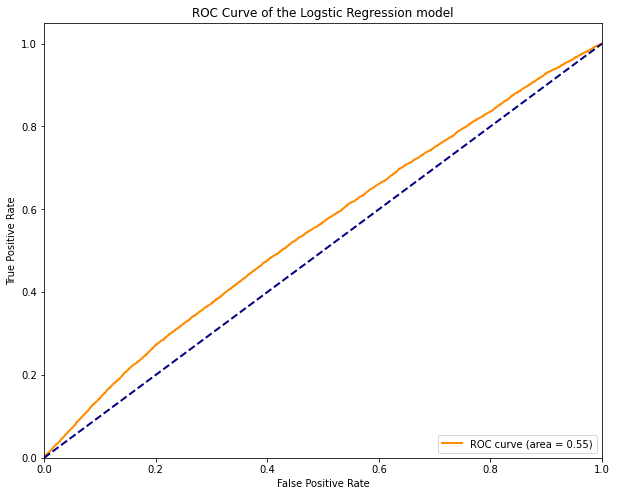

In [550]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_val_class, y_val_class_pred_proba)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('ROC AUC:', roc_auc)

lw = 2
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the Logstic Regression model')
plt.legend(loc="lower right")
plt.show()

<Figure size 720x576 with 0 Axes>

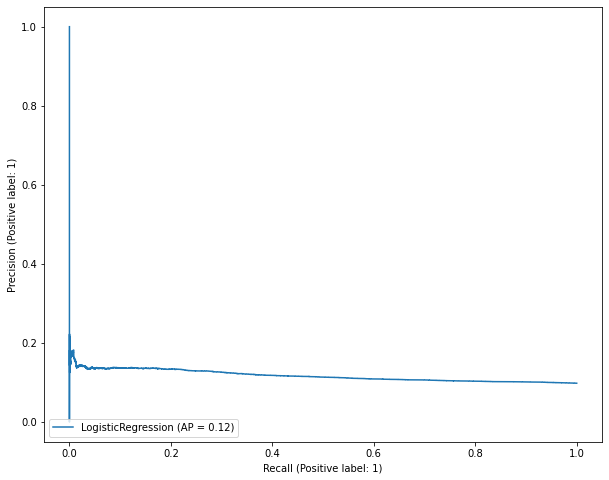

In [551]:
plt.figure()
metrics.plot_precision_recall_curve(clf_LR, X_val_class, y_val_class)

Text(0, 0.5, 'Frequency')

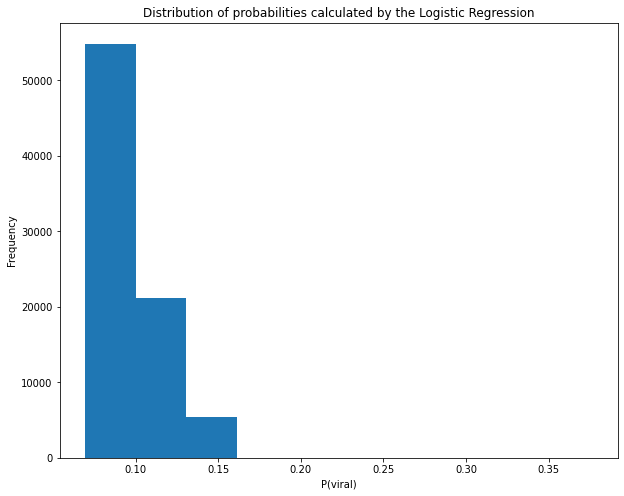

In [552]:
# Displayng the distribution of probabilities calculated by the model
plt.figure()
plt.hist(y_val_class_pred_proba)
plt.title("Distribution of probabilities calculated by the Logistic Regression")
plt.xlabel("P(viral)")
plt.ylabel("Frequency")

In [553]:
# Finding the threshold that maximizes F1 score

# this function takes a threshold and a set of probabilities calculated by the model 
# and converts these into 1s and 0s based on the specified threshold
def metrics_transformation(probabilities, threshold):
    preds = []
    for prob in probabilities:
        if prob > threshold:
            preds.append(1)
        else:
            preds.append(0)
    return preds

thresholds = np.linspace(0.05, 0.20, 10)

def find_max_F1_threshold(predicted_probabilities, true_y):
    thresholds = [i/100 for i in range(100)]
    max_F1 = -1
    best_threshold = -1
    for threshold in thresholds:
        preds = metrics_transformation(predicted_probabilities, threshold)
        F1 = metrics.f1_score(true_y, preds)
        if F1>max_F1:
            best_threshold = threshold
            max_F1 = F1
    return best_threshold


def print_metrics(threshold, predicted_probabilities, true_y):
    preds = metrics_transformation(predicted_probabilities, threshold)
    cm = metrics.confusion_matrix(true_y, preds)
    precision = metrics.precision_score(true_y, preds)
    accuracy = metrics.accuracy_score(true_y, preds)
    f1 = metrics.f1_score(true_y, preds)
    print('For',threshold,'threshold, the obtained metrics are:')
    print("F1 Score =", f1)
    print("Precision =", precision)
    print("Accuracy =", accuracy)
    print()
    print("Confusion matrix:")
    print(cm)
    print()
    cm_norm = metrics.confusion_matrix(true_y, preds, normalize='true')
    print("Normalized confusion matrix:")
    print(cm_norm)



best_threshold = find_max_F1_threshold(y_val_class_pred_proba, y_val_class)
print_metrics(best_threshold, y_val_class_pred_proba, y_val_class)

For 0.09 threshold, the obtained metrics are:
F1 Score = 0.1842854016196104
Precision = 0.10648274251916418
Accuracy = 0.40534868308009525

Confusion matrix:
[[27554 45925]
 [ 2526  5473]]

Normalized confusion matrix:
[[0.37499149 0.62500851]
 [0.31578947 0.68421053]]


#### Linear Discriminant Analysis

In [554]:
%%time
clf_LDA = LDA(solver='eigen', shrinkage='auto', n_components = 1)
clf_LDA = clf_LDA.fit(X_train_class, y_train_class)
y_val_class_pred_proba = clf_LDA.predict_proba(X_val_class)[:,1]

CPU times: user 980 ms, sys: 209 ms, total: 1.19 s
Wall time: 933 ms


ROC AUC: 0.5518456243699443


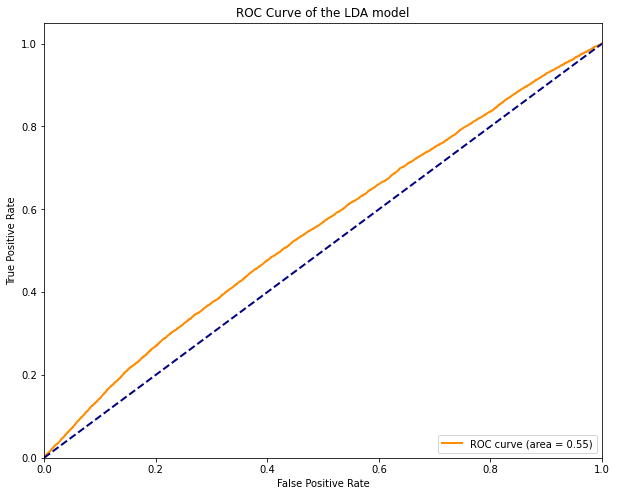

In [555]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_val_class, y_val_class_pred_proba)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('ROC AUC:', roc_auc)

lw = 2
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the LDA model')
plt.legend(loc="lower right")
plt.show()

<Figure size 720x576 with 0 Axes>

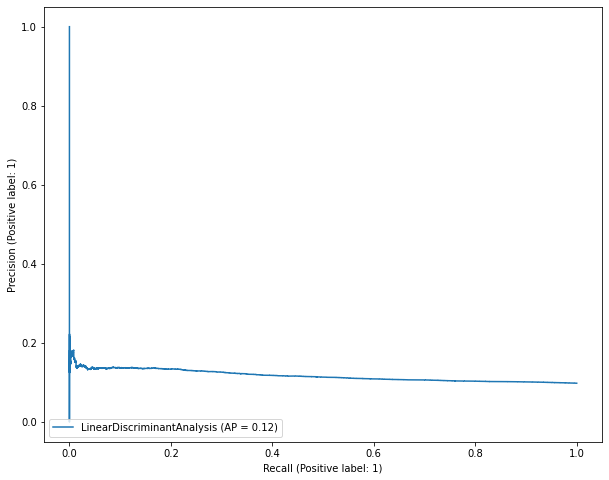

In [556]:
plt.figure()
metrics.plot_precision_recall_curve(clf_LDA, X_val_class, y_val_class)

Text(0, 0.5, 'Frequency')

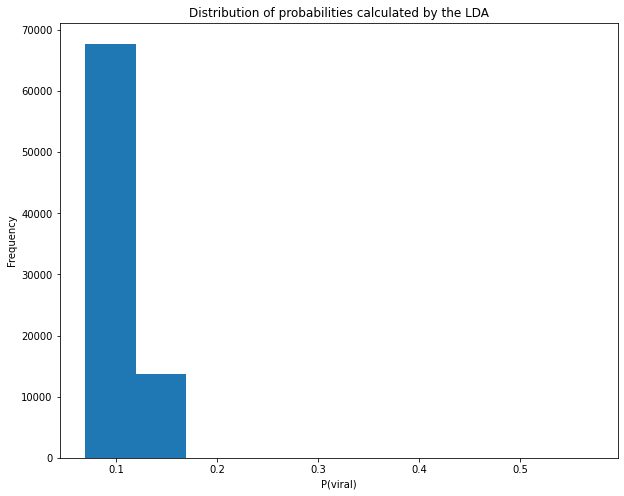

In [557]:
# Displayng the distribution of probabilities calculated by the model
plt.figure()
plt.hist(y_val_class_pred_proba)
plt.title("Distribution of probabilities calculated by the LDA")
plt.xlabel("P(viral)")
plt.ylabel("Frequency")

In [558]:
best_threshold = find_max_F1_threshold(y_val_class_pred_proba, y_val_class)
print_metrics(best_threshold, y_val_class_pred_proba, y_val_class)

For 0.09 threshold, the obtained metrics are:
F1 Score = 0.18409495758302616
Precision = 0.10716632443531827
Accuracy = 0.43222710424899974

Confusion matrix:
[[29998 43481]
 [ 2780  5219]]

Normalized confusion matrix:
[[0.4082527  0.5917473 ]
 [0.34754344 0.65245656]]


#### Gradient Boosted Trees

In [559]:
%%time
clf_GBT = GradientBoostingClassifier()
clf_GBT = clf_GBT.fit(X_train_class, y_train_class)
y_val_class_pred_proba = clf_GBT.predict_proba(X_val_class)[:,1]

CPU times: user 30.9 s, sys: 990 ms, total: 31.9 s
Wall time: 32.6 s


ROC AUC: 0.5598113268357023


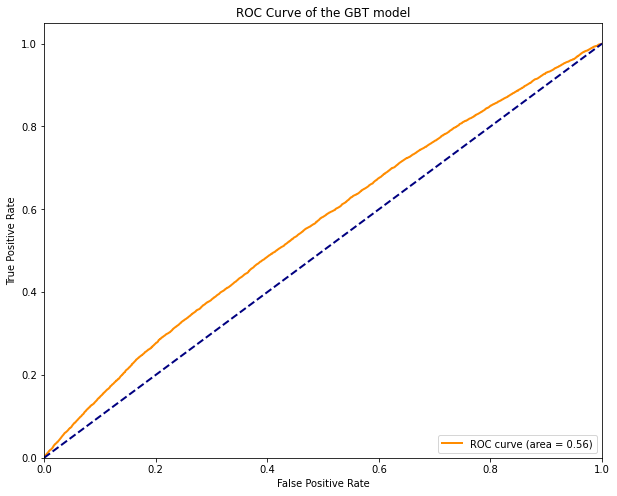

In [560]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_val_class, y_val_class_pred_proba)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('ROC AUC:', roc_auc)

lw = 2
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the GBT model')
plt.legend(loc="lower right")
plt.show()

<Figure size 720x576 with 0 Axes>

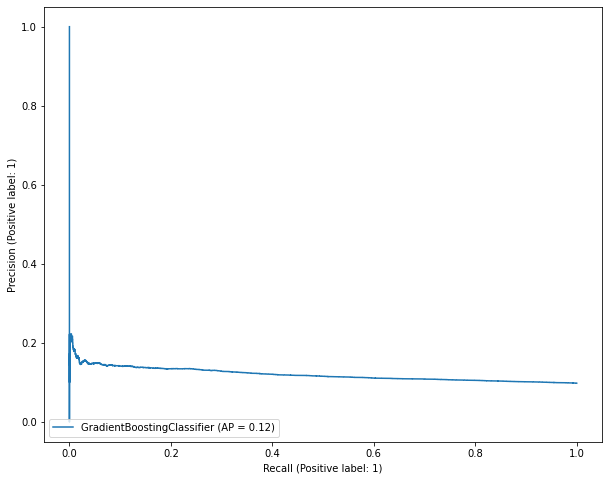

In [561]:
plt.figure()
metrics.plot_precision_recall_curve(clf_GBT, X_val_class, y_val_class)

Text(0, 0.5, 'Frequency')

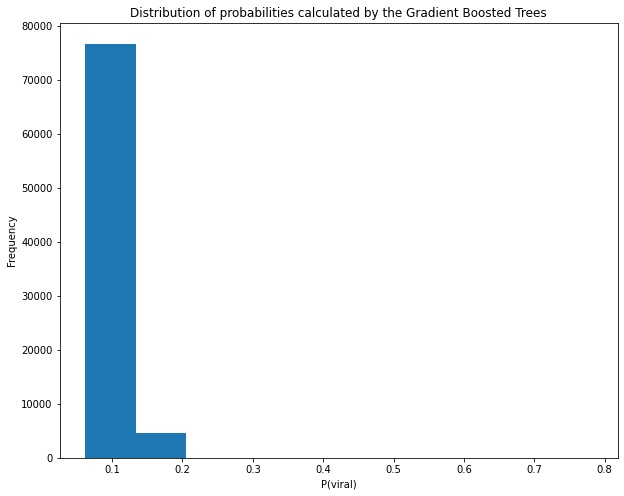

In [562]:
# Displayng the distribution of probabilities calculated by the model
plt.figure()
plt.hist(y_val_class_pred_proba)
plt.title("Distribution of probabilities calculated by the Gradient Boosted Trees")
plt.xlabel("P(viral)")
plt.ylabel("Frequency")

In [563]:
best_threshold = find_max_F1_threshold(y_val_class_pred_proba, y_val_class)
print_metrics(best_threshold, y_val_class_pred_proba, y_val_class)

For 0.09 threshold, the obtained metrics are:
F1 Score = 0.188253519229474
Precision = 0.10877814318239312
Accuracy = 0.40833108323719286

Confusion matrix:
[[27680 45799]
 [ 2409  5590]]

Normalized confusion matrix:
[[0.37670627 0.62329373]
 [0.30116265 0.69883735]]


All the models' performance is far from perfect. It might be the case that the problem is hard in nature and with the features given it is really hard to achieve a good performance. However, it can also be for other reasons. One of them that comes to mind is the fact that the dataset is highly unbalanced. This might skew the distribution and make the model overpredict the majority class. In fact, as we can see by differing metrics values at different (lower) thresholds, this is the case. We could try to make the model 'focus' on the positive samples more by changing the sampling method. In particular, we can achieve a more balanced distribution on the dependent varibale by either downsampling, oversampling, or a mixture of both. These approaches are tried below.

#### Downsampling

In [564]:
y = df['viral']
X = df.copy(deep=False)
X = X.drop(columns=['title', 'author', 'timestamp', 'title_cleaned', 'up_votes', 'month', 'day_of_week'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

df_train_negative = X_train[X_train['viral']==0]
df_train_positive = X_train[X_train['viral']==1]

# downsampling
# here, I am taking downsampling to a ratio of 1
# however, it is possible I could achieve a better result if another downsampling ratio was chosen
# to find the optimal one, I would need to run experiments with different ratios and that's beyond the scope of this assignment
df_train_negative = df_train_negative.sample(len(df_train_positive))

X_train = pd.concat([df_train_negative, df_train_positive])

y_train = X_train['viral']
X_train = X_train.drop(columns=['viral'])

X_val = X_val.drop(columns=['viral'])
X_test = X_test.drop(columns=['viral'])

X_train = MinMaxScaler().fit_transform(X_train)
X_val = MinMaxScaler().fit_transform(X_val)

print("% of viral videos on the train set:", "{0:.3f}".format(y_train.mean()))
print("% of viral videos on the validation set:", "{0:.3f}".format(y_val.mean()))
print("% of viral videos on the test set:", "{0:.3f}".format(y_test.mean()))

% of viral videos on the train set: 0.500
% of viral videos on the validation set: 0.098
% of viral videos on the test set: 0.099


In [565]:
%%time
clf_GBT = GradientBoostingClassifier().fit(X_train, y_train)
y_pred_val = clf_GBT.predict_proba(X_val)[:,1]

CPU times: user 2.8 s, sys: 121 ms, total: 2.92 s
Wall time: 2.96 s


ROC AUC: 0.5564667594159813


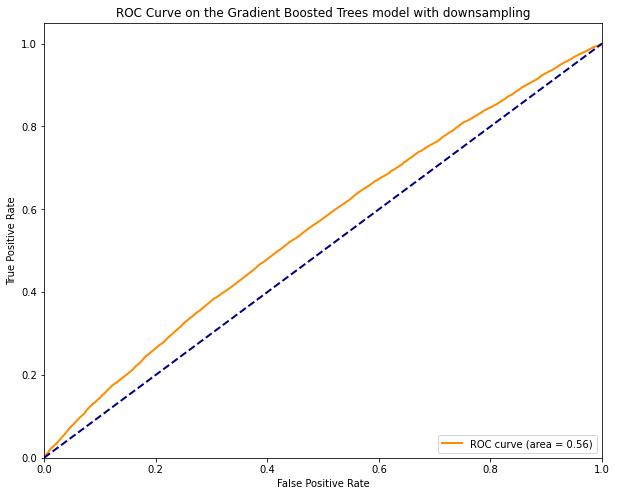

In [566]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_val, y_pred_val)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('ROC AUC:', roc_auc)

lw = 2
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on the Gradient Boosted Trees model with downsampling')
plt.legend(loc="lower right")
plt.show()

<Figure size 720x576 with 0 Axes>

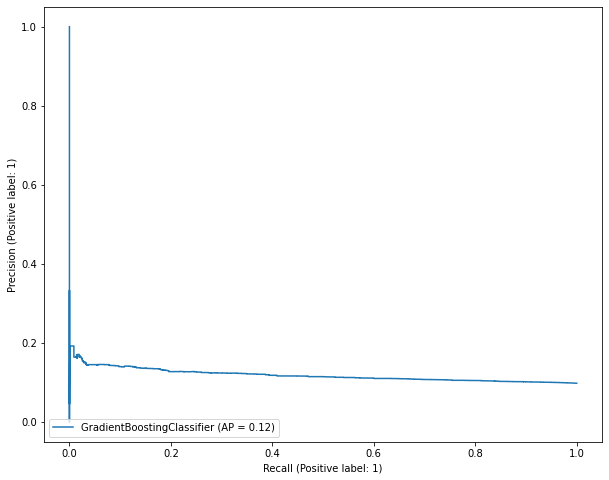

In [567]:
plt.figure()
metrics.plot_precision_recall_curve(clf_GBT, X_val, y_val)

Text(0, 0.5, 'Frequency')

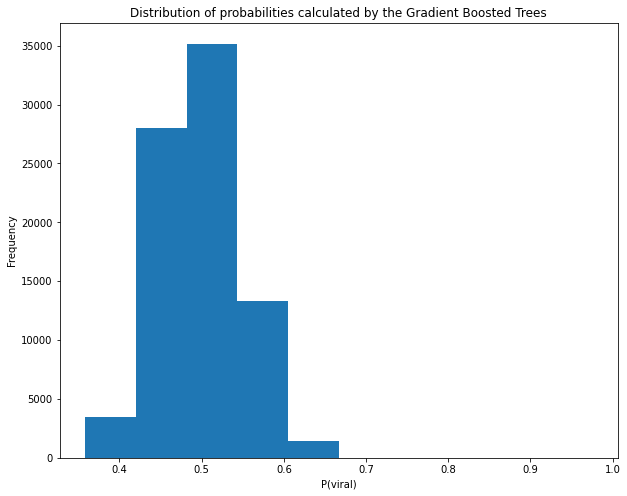

In [568]:
# Displayng the distribution of probabilities calculated by the model
plt.figure()
plt.hist(y_pred_val)
plt.title("Distribution of probabilities calculated by the Gradient Boosted Trees")
plt.xlabel("P(viral)")
plt.ylabel("Frequency")

In [569]:
best_threshold = find_max_F1_threshold(y_pred_val, y_val)
print_metrics(best_threshold, y_pred_val, y_val)

For 0.49 threshold, the obtained metrics are:
F1 Score = 0.18734586450583385
Precision = 0.11228697769165798
Accuracy = 0.5187289820565061

Confusion matrix:
[[37745 35734]
 [ 3479  4520]]

Normalized confusion matrix:
[[0.51368418 0.48631582]
 [0.43492937 0.56507063]]


#### Oversampling

In [570]:
# I will use Synthetic Minority Oversampling TEchnique in this project
# the parameter 'sampling_strategy' asks the question
# "How unbalanced do you want the dataset to be after the oversampling?"
# In our model, let's use 0.5

y = df['viral']
X = df.copy(deep=False)
X = X.drop(columns=['title', 'author', 'timestamp', 'title_cleaned', 'up_votes', 'month', 'day_of_week', 'viral'])

X = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=156)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0))) 

sm = SMOTE(sampling_strategy=0.5) 
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0))) 

Before OverSampling, counts of label '1': 32165
Before OverSampling, counts of label '0': 293745
After OverSampling, counts of label '1': 146872
After OverSampling, counts of label '0': 293745


In [571]:
%%time
clf_GBT = GradientBoostingClassifier().fit(X_train, y_train)
y_pred_val = clf_GBT.predict_proba(X_val)[:,1]

CPU times: user 34.5 s, sys: 1.37 s, total: 35.9 s
Wall time: 37 s


ROC AUC: 0.549912169678701


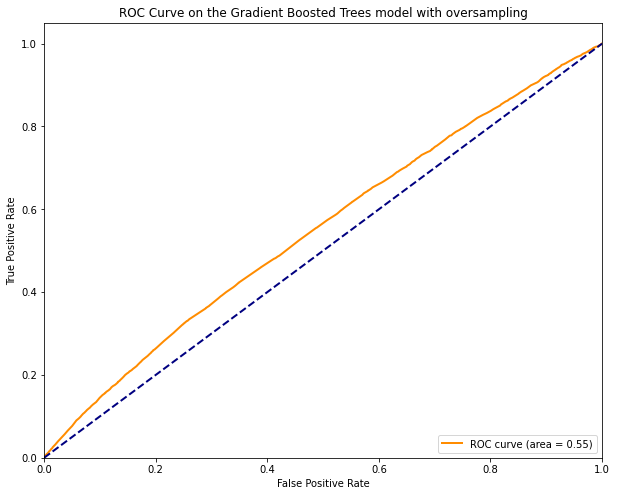

In [572]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_val, y_pred_val)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('ROC AUC:', roc_auc)

lw = 2
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on the Gradient Boosted Trees model with oversampling')
plt.legend(loc="lower right")
plt.show()

<Figure size 720x576 with 0 Axes>

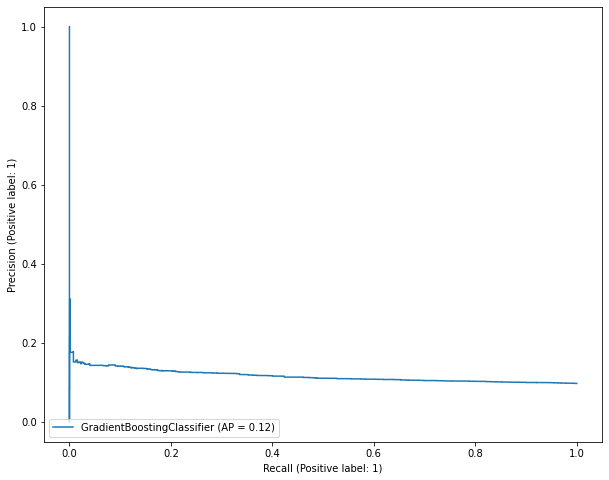

In [573]:
plt.figure()
metrics.plot_precision_recall_curve(clf_GBT, X_val, y_val)

Text(0, 0.5, 'Frequency')

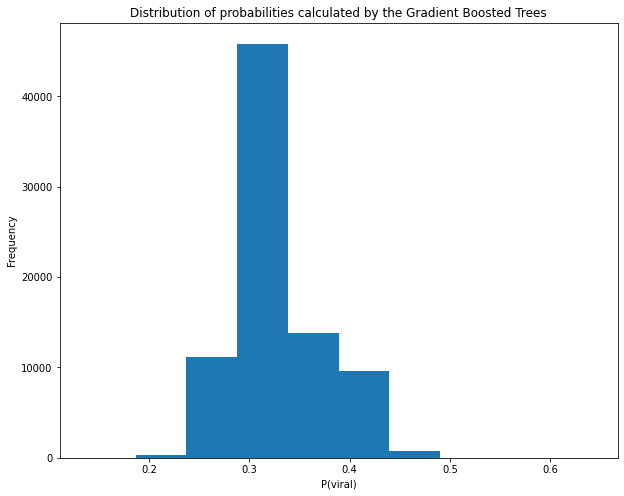

In [574]:
# Displayng the distribution of probabilities calculated by the model
plt.figure()
plt.hist(y_pred_val)
plt.title("Distribution of probabilities calculated by the Gradient Boosted Trees")
plt.xlabel("P(viral)")
plt.ylabel("Frequency")

In [575]:
best_threshold = find_max_F1_threshold(y_pred_val, y_val)
print_metrics(best_threshold, y_pred_val, y_val)

For 0.32 threshold, the obtained metrics are:
F1 Score = 0.1841344843253067
Precision = 0.10764065952745198
Accuracy = 0.44901691254080855

Confusion matrix:
[[31519 41998]
 [ 2895  5066]]

Normalized confusion matrix:
[[0.42873077 0.57126923]
 [0.36364778 0.63635222]]


Neither the downsampling nor the oversampling improved the performance of the model so I will abandon this practice. Now, I want to conduct the hyperparameter tuning of the so-far best-performing algorithm - GBT. This will be done on the training data and the model with best params will be checked on the validation set.

In [576]:
# values for parameter grid
learning_rate = [0.1, 0.01] 
n_estimators = [50, 100, 200]
min_samples_split = [2, 10]
max_depth = [3, 6, 10]

# Create the random grid
random_grid = {
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'criterion': criterion,
    'min_samples_split': min_samples_split,
    'max_depth': max_depth
    }

gbt_clf = GradientBoostingClassifier()

#using the RandomizedSearchCV from scikit-learn to run the CV and obtain the parameters
gbt_clf_random = RandomizedSearchCV(estimator = gbt_clf, param_distributions = random_grid, cv = 5, verbose=2, random_state=123, n_jobs=1)

# Fit the random search model
gbt_clf_random.fit(X_train_class, y_train_class)
print("Best parameters:", gbt_clf_random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=50; total time=  22.5s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=50; total time=  22.2s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=50; total time=  20.7s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=50; total time=  21.5s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=50; total time=  22.2s
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=200; total time= 1.6min
[CV] END criterion=mse, learning_rate=0.1, max_depth=6, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END criterion=mse, learning

In [577]:
%%time
clf_GBT = GradientBoostingClassifier(n_estimators = 200, min_samples_split = 10, max_depth = 3, learning_rate = 0.01).fit(X_train_class, y_train_class)
y_pred_test = clf_GBT.predict_proba(X_test_class)[:,1]

CPU times: user 1min 4s, sys: 2.31 s, total: 1min 6s
Wall time: 1min 8s


ROC AUC: 0.5540319440522765


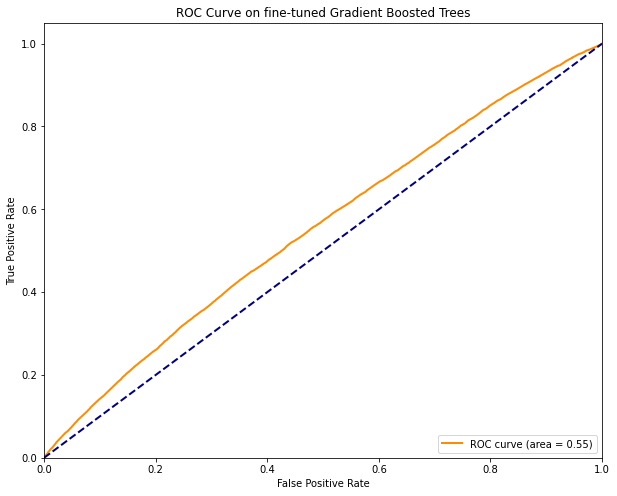

In [578]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test_class, y_pred_test)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('ROC AUC:', roc_auc)

lw = 2
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on fine-tuned Gradient Boosted Trees')
plt.legend(loc="lower right")
plt.show()

<Figure size 720x576 with 0 Axes>

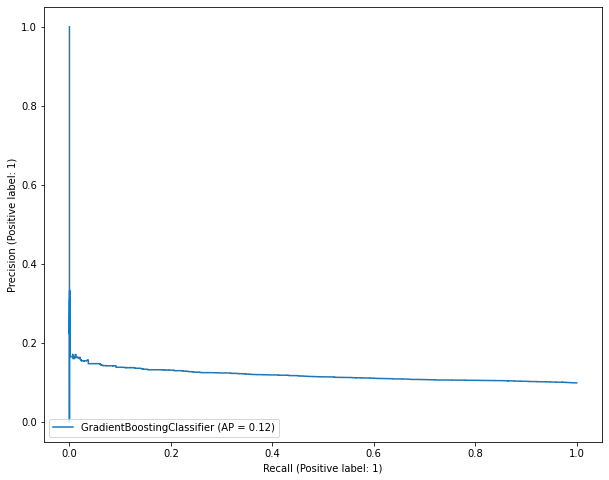

In [579]:
plt.figure()
metrics.plot_precision_recall_curve(clf_GBT, X_test_class, y_test_class)

Text(0, 0.5, 'Frequency')

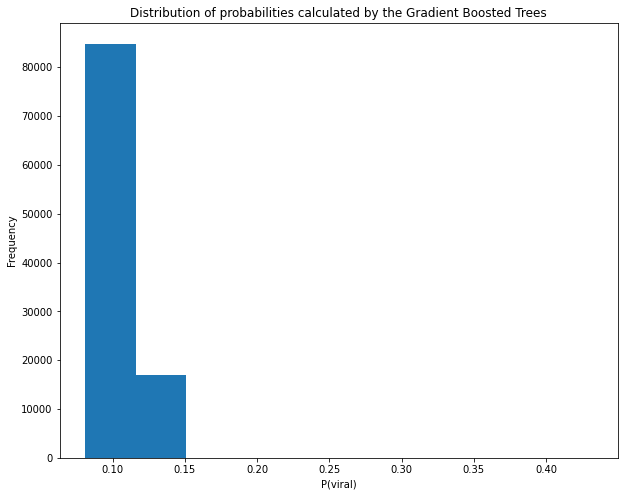

In [580]:
# Displayng the distribution of probabilities calculated by the model
plt.figure()
plt.hist(y_pred_test)
plt.title("Distribution of probabilities calculated by the Gradient Boosted Trees")
plt.xlabel("P(viral)")
plt.ylabel("Frequency")

In [581]:
best_threshold = find_max_F1_threshold(y_pred_test, y_test_class)
print_metrics(best_threshold, y_pred_test, y_test_class)

For 0.09 threshold, the obtained metrics are:
F1 Score = 0.18631231065822088
Precision = 0.10534374918896473
Accuracy = 0.3037860340900165

Confusion matrix:
[[22822 68944]
 [ 1964  8118]]

Normalized confusion matrix:
[[0.24869777 0.75130223]
 [0.19480262 0.80519738]]


The continuation of this experiment is in the google colab notebook. The Neural Nets trained there perform much better than the algorithms used here.